In [50]:
# An example plotting script for DCMIP 2025 test case 2a: Gap flow

In [51]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import matplotlib
import matplotlib.colors as colors

In [52]:
# A function to perform interpolation to a constant altitude

def z_interp(h, field_vals_all, lon, lat, z_val):
    field_vals = np.zeros((len(lat), len(lon)))
    for i in np.arange(len(lat)):
        for j in np.arange(len(lon)):
            if h[-1,i,j] > z_val:
                # This value is inside the topography
                field_vals[i,j] = np.nan
            else:
                # Find indices either side of this value
                low_idx = np.where(h[:,i,j] < z_val)[0][0]
                high_idx = np.where(h[:,i,j] > z_val)[0][-1]

                # Compute weightings
                weight_low = (z_val - h[low_idx,i,j])/(h[high_idx,i,j] - h[low_idx,i,j])
                weight_high = 1. - weight_low

                # Compute and store value
                field_vals[i,j] = weight_low*field_vals_all[low_idx, i, j] + weight_high*field_vals_all[high_idx, i, j]
    return field_vals

In [53]:
# Parameters from the simulation:
rot = False
u0 = 10
T0 = 288
h_val = 1500
small_earth_fact = 20

In [54]:
# Information about the paths

# Name of your CAM clone:
CAM_dirname = 'CAM_6_4_060_06032025'

# Edit this to your own case name
case = 'cam_6_4_060_horiz_mount_flow_se_ne30_30km_L38'

# Modify the following according to your naming convention
if rot:
    nc_file = case + f'.cam.h0i.0001-01-01-00000_gap_with_rot_RF_15km_tau_1_10th_day.nc'
else:
    nc_file = case + f'.cam.h0i.0001-01-01-00000_gap_omega0_RF_15km_tau_1_10th_day.nc'

# Define the base root to the data,
# add your username
username = 'timand'
run_base = f'/glade/derecho/scratch/{username}/'
output_base = f'/glade/u/home/{username}/'

In [55]:
# Automatically set some paths
run_path = run_base + case + '/run/' + nc_file
output_dir = f'{CAM_dirname}/plotting/'
output_file = output_base + output_dir

In [56]:
# Specify the altitude, field and times you want to plot
z_val = 300 # in metres
field = 'T'
t_idxs = [10,20,40] # Each index is 0.25 small Earth hours

In [57]:
# Extract the data
nc = Dataset(run_path)
time = nc['time'][:]
lat = nc['lat'][:] 
lon = nc['lon'][:] 
lev = nc['lev'][:]

print(f'There are {len(time)} time samples')
print(f'{len(lat)} latitiude points, {len(lon)} longitude points')

There are 41 time samples
257 latitiude points, 512 longitude points


In [58]:
# Crop to the subdomain of interest

lon_crop_left = 70.
lon_crop_right = 170.
lon_ticks = np.linspace(80, 160, 6) # Plotting ticks

lat_crop_up = 50.
lat_crop_down = -50.
lat_ticks = np.linspace(-40,40,5) # Plotting ticks

lon_inds = np.where((lon > lon_crop_left) & (lon < lon_crop_right))[0]
lat_inds = np.where((lat > lat_crop_down) & (lat < lat_crop_up))[0]

print(f'Crop is of size, {len(lat_inds)} lat vals and {len(lon_inds)} lon vals')

lat = lat[lat_inds] 
lon = lon[lon_inds] 
LON, LAT = np.meshgrid(lon, lat)

Crop is of size, 143 lat vals and 142 lon vals


In [59]:
# Interpolate the data at each time index:
field_vals1 = z_interp(nc['Z3'][t_idxs[0], :, lat_inds, lon_inds], nc[field][t_idxs[0], :, lat_inds, lon_inds], lon, lat, z_val)
print('interpolated time 1')
field_vals2 = z_interp(nc['Z3'][t_idxs[1], :, lat_inds, lon_inds], nc[field][t_idxs[1], :, lat_inds, lon_inds], lon, lat, z_val)
print('interpolated time 2')
field_vals3 = z_interp(nc['Z3'][t_idxs[2], :, lat_inds, lon_inds], nc[field][t_idxs[2], :, lat_inds, lon_inds], lon, lat, z_val)
print('interpolated time 3')

interpolated time 1
interpolated time 2
interpolated time 3


In [60]:
# Normalise the data:
if field == 'U':
    # Normalised wind perturbation
    field_vals1 = (field_vals1 - u0*np.cos(LAT*deg2rad))/(u0*np.cos(LAT*deg2rad))
    field_vals2 = (field_vals2 - u0*np.cos(LAT*deg2rad))/(u0*np.cos(LAT*deg2rad))
    field_vals3 = (field_vals3 - u0*np.cos(LAT*deg2rad))/(u0*np.cos(LAT*deg2rad))
elif field == 'T':
    field_vals1 = field_vals1 - T0
    field_vals2 = field_vals2 - T0
    field_vals3 = field_vals3 - T0

Text(0.5, 0.98, 'SE dycore ne30, gap flow test case')

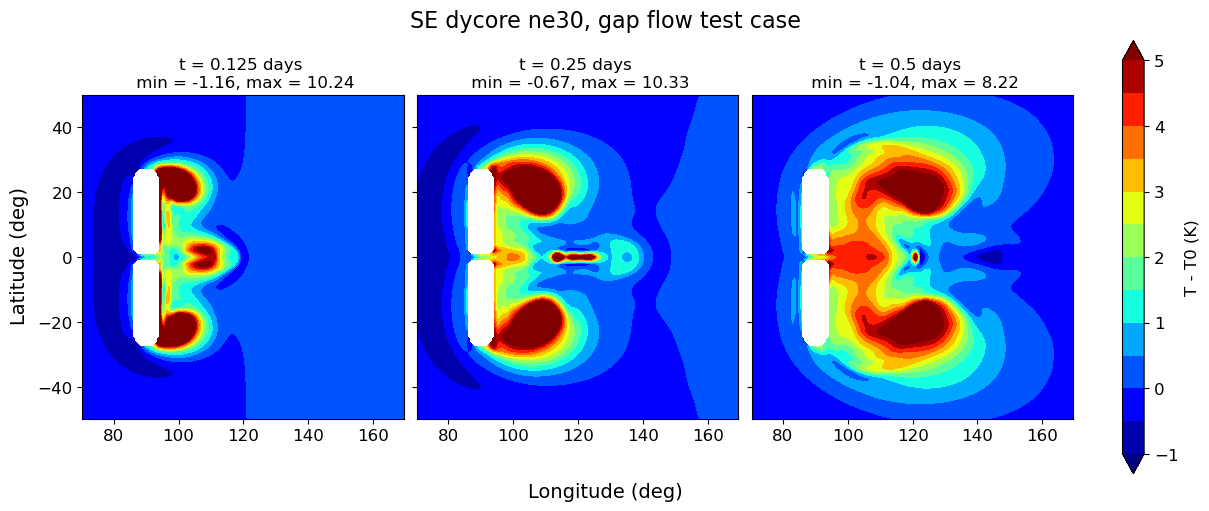

In [64]:
# Make the plot!
fig, axes = plt.subplots(1,3,figsize = (12,5), sharey=True, layout="constrained")
ax1, ax2, ax3 = axes

title_size=16
label_size=14
small_size=12

# For the title
dycore_res = 'SE ne60'

# Feel free to add additional fields, such as V, OMEGA
if field == 'T':
    # Choose the colormap
    cmap_choice = 'jet'
    
    # Choose the range of colours
    minmin = -1
    maxmax = 5
    
    conts = np.linspace(minmin, maxmax, 13)
    tick_range = np.linspace(minmin, maxmax, 7)
    norm = colors.Normalize(vmin = minmin, vmax = maxmax)
    
    plot1 = ax1.contourf(LON, LAT, field_vals1, levels = conts, cmap=cmap_choice, norm=norm, extend = 'both')
    plot2 = ax2.contourf(LON, LAT, field_vals2, levels = conts, cmap=cmap_choice, norm=norm, extend = 'both')
    plot3 = ax3.contourf(LON, LAT, field_vals3, levels = conts, cmap=cmap_choice, norm=norm, extend = 'both')
    title = 'Temperature perturbation'
    cb_label = 'T - T0 (K)'
elif field == 'U':
    cmap_choice = 'seismic'
    
    # Choose the range of colours
    minmin = -1
    maxmax = 0.5
    
    conts = np.linspace(minmin, maxmax, 10)
    tick_range = np.linspace(minmin, maxmax, 4)
    norm = colors.Normalize(vmin = minmin, vmax = maxmax)
    
    plot1 = ax1.contourf(LON, LAT, field_vals1, levels = conts, cmap=cmap_choice, norm=norm, extend = 'both')
    plot2 = ax2.contourf(LON, LAT, field_vals2, levels = conts, cmap=cmap_choice, norm=norm, extend = 'both')
    plot3 = ax3.contourf(LON, LAT, field_vals3, levels = conts, cmap=cmap_choice, norm=norm, extend = 'both')
    title = 'Normalised velocity perturbation'
    cb_label = '$(u(t) - u_0)/u_0$'

ax1.set_aspect('equal')
ax2.set_aspect('equal')
ax3.set_aspect('equal')

ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
ax3.tick_params(axis='both', labelsize=12)

cb = plt.colorbar(plot3, ax=axes, ticks = tick_range, fraction=0.4)
cb.set_label(label=cb_label, size=small_size)
cb.ax.tick_params(labelsize=12)

ax1.set_title(f't = {time[t_idxs[0]]} days \n min = {np.round(np.nanmin(field_vals1),2)}, max = {np.round(np.nanmax(field_vals1),2)}')
ax2.set_title(f't = {time[t_idxs[1]]} days \n min = {np.round(np.nanmin(field_vals2),2)}, max = {np.round(np.nanmax(field_vals2),2)}')
ax3.set_title(f't = {time[t_idxs[2]]} days \n min = {np.round(np.nanmin(field_vals3),2)}, max = {np.round(np.nanmax(field_vals3),2)}')

fig.supylabel('Latitude (deg)', size=label_size)
fig.supxlabel('Longitude (deg)', size=label_size)

fig.suptitle('SE dycore ne30, gap flow test case', size=title_size)